In [1]:
#fetch_mldata is deprecated fetch_openml is the 

from sklearn.datasets import fetch_openml

import pandas as pd

# Load the MNIST dataset
mnist = fetch_openml(name='mnist_784', version=1, parser="auto")



In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

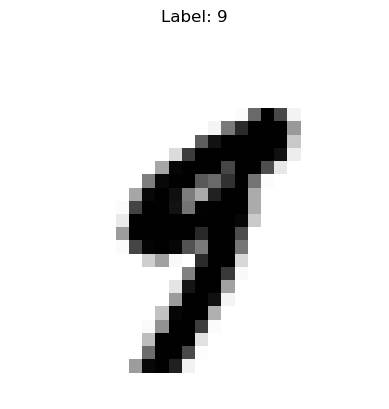

In [3]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt


# Get the features (pixel values) and labels from the dataset
# The Features must be convert to numpy array
X = mnist.data.to_numpy()
y = mnist.target

# Access the 36000th image and its corresponding label
image_index = 36000
image = X[image_index]
label = y[image_index]

# Reshape the image to its original 28x28 dimensions
image = image.reshape(28, 28)

# Display the image
plt.imshow(image, cmap='binary')
plt.axis('off')
plt.title(f"Label: {label}")
plt.show()


In [4]:
y[36000]

'9'

In [5]:
import numpy as np

#splitting the dataset to 60000 training set and 10000 testset
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
unique_classes = np.unique(y_train)
print("Unique classes in y_train:", unique_classes)

#shuffling dataset 
shuffled_index = np.random.permutation(60000) 
X_train, y_train = X_train[shuffled_index], y_train[shuffled_index]

X_train shape: (60000, 784)
y_train shape: (60000,)
Unique classes in y_train: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


## Training the binary classifier

In [6]:
# #converting y_train to interger
y_train = y_train.astype(int)

# Creating a target vector for binary classification
y_train_9 = (y_train == 9)
y_test_9 = (y_test ==  9)

# unique_classes = np.unique(y_train_9)
# print(unique_classes)

# Reshape `image` to a 1D array with shape (784,)
image = image.reshape(784)  

from sklearn.linear_model import SGDClassifier

# Create SGDClassifier model
SGD_clf = SGDClassifier( random_state=42, max_iter=1000)

# Fit on training data  
SGD_clf.fit(X_train, y_train_9)

# Make prediction
prediction = SGD_clf.predict([image])

if prediction[0] == 1:
  print("The image is a 9")
else:
  print("The image is not a 9")

The image is not a 9


In [7]:
print(y_train_9)

55141    False
22975    False
22552     True
7003     False
28990    False
         ...  
3778     False
25336    False
44356    False
49302    False
6032     False
Name: class, Length: 60000, dtype: bool


## Performance Measure

* Using cross valadation (cross_val_score)
* cvscore shows a mean accuracy of 93%
* using a dumb classifier to verify the accuracy which confirm the cvscore with the model having more than 90% accuracy meaning 10% of the image are 9, 90% are not 9

In [8]:
from sklearn.model_selection import cross_val_score

cvscore = cross_val_score(SGD_clf, X_train, y_train_9, cv=3, scoring='accuracy')
print(cvscore)
cvscore.mean()


[0.82685 0.92265 0.93445]


0.89465

In [9]:
from sklearn.base import BaseEstimator

class not9classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros(len(X), dtype=bool)
    
not_9_clf = not9classifier() 
cross_val_score(not_9_clf, X_train, y_train_9, cv=3, scoring='accuracy') 



array([0.90085, 0.90085, 0.90085])

### Evaluationg using confusin matrix

In [10]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(SGD_clf, X_train, y_train_9, cv=3) 

In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_9, y_train_pred)

#TN of 50678 correctly classified as non 9s, FP- 3373 is wrongly classified as  9s
#FN of 752 wrongly classified as  non 9s, TP- 5195 is correctly classified as  9s

array([[49495,  4556],
       [ 1765,  4184]], dtype=int64)

In [12]:
confusion_matrix(y_train_9, y_train_pred)

array([[49495,  4556],
       [ 1765,  4184]], dtype=int64)